# A Survival Analysis on The Worcester Heart Attack Study Patients
### Jiaqing (Jack) Zhao

***

### A) Load the dataset


> I am using the Worcester Heart Attack Study 500 dataset which is a public data set from the Worcester Heart Attack Study. The dataset recorded 500 individuals who were admitted to hospital because of having a heart attach. The covariates contained some of the health status from the individuals. We are trying to use this dataset to fit a Cox regression model on the number of days they can live starting from their admission day to the hospital.

> Due to the fact that this dataset is for demo only I will not be discussing into any medical insights or nature of the covariates. Namely, we won't be doing inferences.

In [18]:
from coxph import * # my implementation on Cox Regression
import whas_clean # my script
from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [55]:
whas = pd.read_csv("whas500.csv")
whas.head(3)

,id,age,gender,hr,sysbp,diasbp,bmi,cvd,afb,sho,...,miord,mitype,year,admitdate,disdate,fdate,los,dstat,lenfol,fstat
0,1,83,0,89,152,78,25.54051,1,1,0,...,1,0,1,1/13/1997,1/18/1997,12/31/2002,5,0,2178,0
1,2,49,0,84,120,60,24.02398,1,0,0,...,0,1,1,1/19/1997,1/24/1997,12/31/2002,5,0,2172,0
2,3,70,1,83,147,88,22.14290,0,0,0,...,0,1,1,1/1/1997,1/6/1997,12/31/2002,5,0,2190,0


### B) What is our y variable? What are the events and how should we calculate the timeline? 

> We have two sets of time to event variables. The first set records the individual's status at the day of discharge from the hospital and the second set contains the indivisual's status at the day of hospital follow up. It is crucial to decide which data to use for each individual. 
>- __Group 1__. Deceased at hospital <- Small group only 7.8%
>- __Group 2__. Survived at discharge but found deceased during followup <- Not perfectly censored, our focus
>> that is, if a person dies between the discharge date and followup date... how can we know?
>- __Group 3__. Survived follow up <- Perfectly right censored

> I can't find much information on the way the dataset is collected and how the follow ups were performed. So how to solve this problem?

> - We can try to see if there is a difference in followups for the deceased and alive group and infer the validity of the follow up date as our final date for group 2
> - Penalize very long time gaps between discharge and followup for group 2

In [3]:
whas['group'] = whas.apply(whas_clean.groups, axis=1)
whas['after_dis'] = whas['lenfol'] - whas['los']

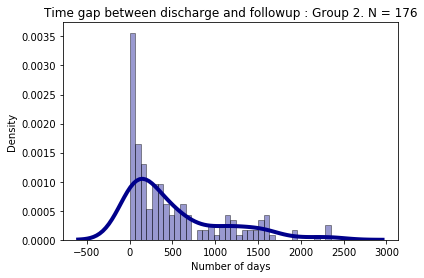

In [4]:
sns.distplot(whas[(whas['dstat'] == 0) & (whas['fstat'] == 1)]['lenfol'] - whas[(whas['dstat'] == 0) & (whas['fstat'] == 1)]['los'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title('Time gap between discharge and followup : Group 2. N = 176')
plt.xlabel('Number of days')
plt.ylabel('Density');

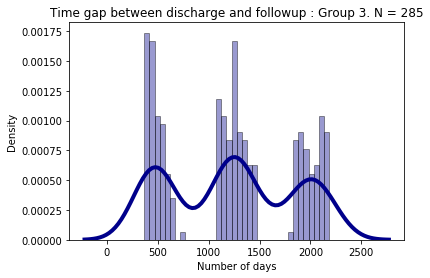

In [5]:
sns.distplot(whas[(whas['dstat'] == 0) & (whas['fstat'] == 0)]['lenfol'] - whas[(whas['dstat'] == 0) & (whas['fstat'] == 0)]['los'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title('Time gap between discharge and followup : Group 3. N = 285')
plt.xlabel('Number of days')
plt.ylabel('Density');

> We can clearly see the pattern in the second plot that there are three humps while in the first graph there aren't. It seems like hospital is following up people in three batches with a 500 to 750 days delay in between. Why are hospital giving different follow up times? Several hypothesis:
> - Hospital follow up patients quickly for those who are at higher risks
> - Has something to do with the cohort. Since there are 3 cohorts to this study (patients adimitted to hospital in 1997, 1999 ans 2001)

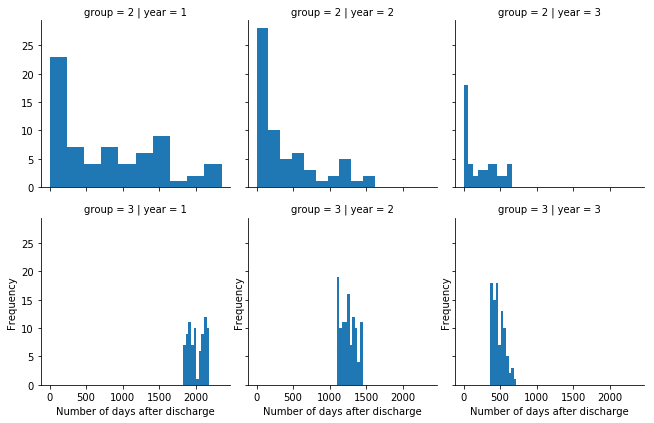

In [6]:
g = sns.FacetGrid(whas[whas["group"] > 1], col="year",row = "group")
g = g.map(plt.hist, "after_dis")

for j in range(3):

    g.axes[1,j].set_xlabel('Number of days after discharge')
    g.axes[1,j].set_ylabel('Frequency')

> __Summary__: it seems like hospitals follow up patients regularly for every 500 to 750 days yet only the latest follow-ups will be recorded. Such that for group 3, people from year 1 have survived 3 follow-ups and people from year 3 have only experienced one follow-up because their cohort is newer. 

> For people in group 2, if they have a follow-up record thats <= 500 days we know thay did not survive the first follow-up. If they have a follow-up record at ~ 1500 days we know they most likely survived the first 500 days checkpoint. Similarly if they have a follow-up record at ~ 2000 days we know they most likely survived the 1500 days checkpoint. This can also explain why the group 2 partient exhibit distributions that are skewed to the right. The distributions at 500, 1500 and 200 are not well distinguished for group 2 because of
>> - Variation in time and
>> - Lower count

> - Our solution: penalize mildly
> - Rubric: Assuming three distinct followup time distributions around ~500, ~1500 and ~2000. We get the mean and quantile of those three distributions from group 3 seperated by year. If any patient's reported follow-up time is larger than the 25th percentile of a distribution and smaller than the 75th of that distribution we resample a followup time (event time) from a normal distribution where the mean is the 25th percentile and a standard deviation of 100 (arbitrary). 

In [7]:
# penalize
whas['time'] = whas.apply(whas_clean.penalize, axis=1)

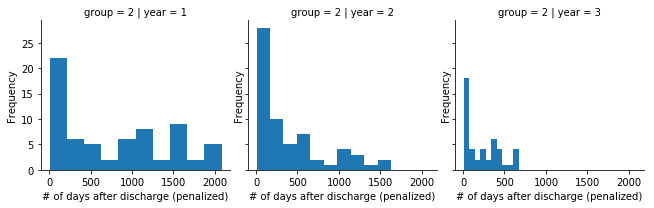

In [8]:
# check the distributions again
g = sns.FacetGrid(whas[whas["group"] == 2], col="year",row ='group')
g = g.map(plt.hist, "time")

for j in range(3):

    g.axes[0,j].set_xlabel('# of days after discharge (penalized)')
    g.axes[0,j].set_ylabel('Frequency')

### C) Exploratory Analysis with the KM Curve

> Now we will do some exploratory analysis with the KM curve. We will breifly check the following aspects to see if anything interesting comes up
> - overall trend
> - by demographics (age, gender)
> - by cohort
> - by simple health features (initial heart rate, bmi)

> We are using scikit-learn survival package to generate these graphs

##### Overall all KM Graph. 
> We can see a huge drop between t = 0 and t = 500. The trend gets slower after that.

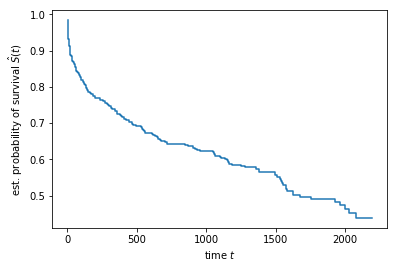

In [9]:
time, survival_prob = kaplan_meier_estimator(whas["fstat"].values.astype('bool'), whas["time"].values)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$");

##### KM curve by demographics
> Higher age => higher risks. And females seem to have higher risks than males. 

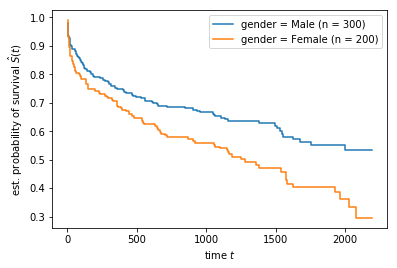

In [10]:
gen_dic = {0:"Male",1:"Female"}
whas_clean.display_km(gen_dic, "gender", whas)

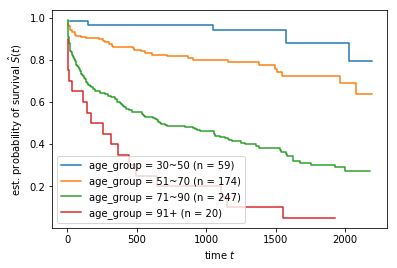

In [11]:
whas['age_group'] = whas.apply(whas_clean.age_group, axis=1)
age_dic = {1:"30~50",2:"51~70",3:"71~90",4:"91+"}
whas_clean.display_km(age_dic, "age_group", whas)

##### KM curve by cohort
> Pretty similar (drops due to shorter time span)

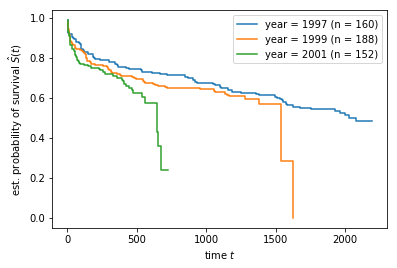

In [12]:
year_dic = {1:"1997",2:"1999",3:"2001"}
whas_clean.display_km(year_dic, "year", whas)

##### KM curve by health status
> Seems like higher heart rates and low body weights lead to more risks.

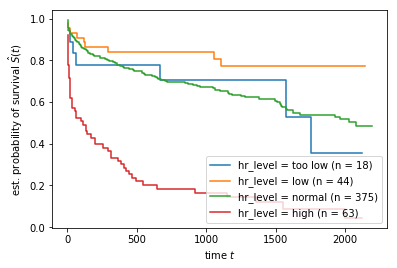

In [13]:
whas['hr_level'] = whas.apply(whas_clean.hr_level, axis=1)
hr_dic = {1:"too low",2:"low",3:"normal",4:"high"}
whas_clean.display_km(hr_dic, "hr_level", whas)

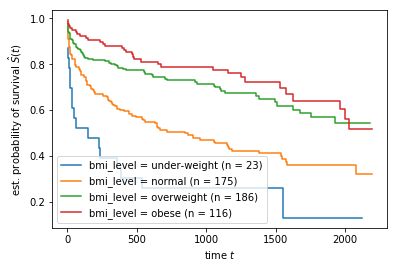

In [14]:
whas['bmi_level'] = whas.apply(whas_clean.bmi_level, axis=1)
bmi_dic = {1:"under-weight",2:"normal",3:"overweight",4:"obese"}
whas_clean.display_km(bmi_dic, "bmi_level", whas)

### D) Predictive Modeling


> I tried to implement the Cox regression myself. I modified the code from Scikit-survival because it is such a well-written package. I ended-up:
> - adding comments, especially on the computation parts 
> - changing coding structure (merged several classes) and variable names (like changing *risk_set* to *sum_risk_j* to fit the original mathametical representations better)
> - changing minor issues (non-essential, found some redundancy in sksurv code)
> - stripping excessive functionalities and rewrote some functions for the sake of simplicity (e.g. we are not doing regularizations)

In [19]:
def cross_validation_cox(X,y,cv,y_name = 'after_dis'):
    c_scores = []
    coef_ = []
    for i in range(cv):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
        cpr = cox_ph_regressor().fit(X_train,y_train)
        prediction = cpr.predict(X_test)
        result = concordance_index_censored(y_test["fstat"].values.astype("bool"), y_test[y_name], prediction)
        c_scores.append(float(result[0]))
        coef_.append(cpr.coef_)
    print("Average cross validation score: " + str(sum(c_scores)/len(c_scores)))
    print("Standard deviation of validation score:" + str(np.std(c_scores)))
    #return coef_

In [20]:
# cross validation
cv = 5
# prepare data 
X = whas.iloc[:,2:14]
y = whas.iloc[:,[-7,-5]]
y_original = whas.iloc[:,[-7,-8]]

In [38]:
# cross validation score for our penalized y
co_ = cross_validation_cox(X,y,cv)

Average cross validation score: 0.7757834684374055
Standard deviation of validation score:0.026766735268062895


In [50]:
# cross validation score for our original y
cross_validation_cox(X,y_original,cv,"lenfol")

Average cross validation score: 0.7119700765848948
Standard deviation of validation score:0.03480471683147719


> We can see that our penalized y yields better results

### E) Summary & Insights


On the study...
> - We used exploratory analysis to figure out the hospitals/researchers' routine to follow up patients and adjusted our time and events accordingly.
> - From KM curve analysis we can see that visually there are huge differences between groups like gender, age, heart rate and etc. That gave us confidence in building a predictive model
> - Our predictive models have a pretty good cross validation result. C-score of .776 is pretty high given that we train on only 400 data points.

On the methods...
> - Another big part of this project is to understand how Cox Regression can be implemented in code
> - We used Newton's method to minimize the negative log partial likelihood function for Cox regression

<img src="img/ll.png" alt="Drawing" style="width: 300px;"/>

> - The predictions are relative risks, assessed by concordence index
> - Possible to perform regularizations

Other insights...
> - With more data we can easily adapt other machine learning methods e.g. Random Survival Forest, SVM and etc...
> - While working with our own data we can perform better feature engineering